In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


cifar_train = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ]))

cifar_test = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ]))


Files already downloaded and verified
Files already downloaded and verified


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 110, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 11, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [3]:
p_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r_list = [1]

# No of correct classification for each type for each p_value
correct = np.zeros((7, 10))

# Total no of samples of each type for each p_value
total = np.zeros((7, 10))

for r in r_list :
    for i, p in enumerate(p_list) :
        D = Discriminator().to(device)
        D.load_state_dict(torch.load(f'./models/cifar10_disc_r_value_{r}_p_value_{p}.pt'))
        D.eval()

        with torch.no_grad():
            for sample in cifar_test :
                input_image = sample[0].view(-1, 3, 32, 32)
                output_value = D(input_image.to(device))
                output_value = output_value.cpu().detach().numpy().reshape(11)
                output_value = output_value[:10]
                output_value = np.argmax(output_value)

                if(output_value == sample[1]) :
                    correct[i][sample[1]] += 1
                
                total[i][sample[1]] += 1

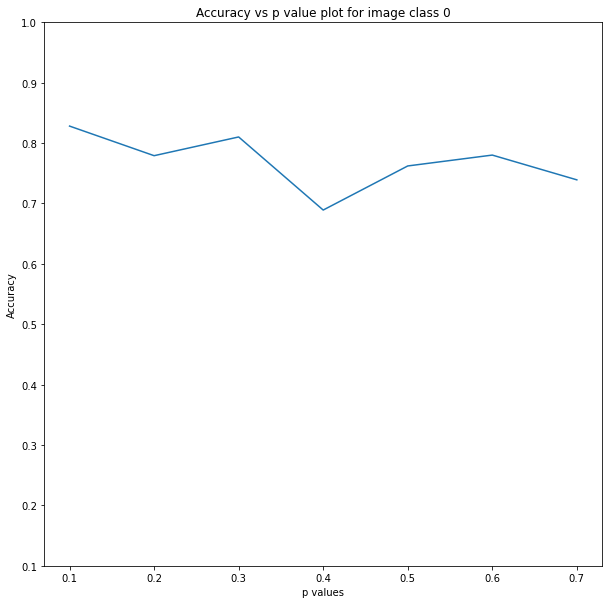

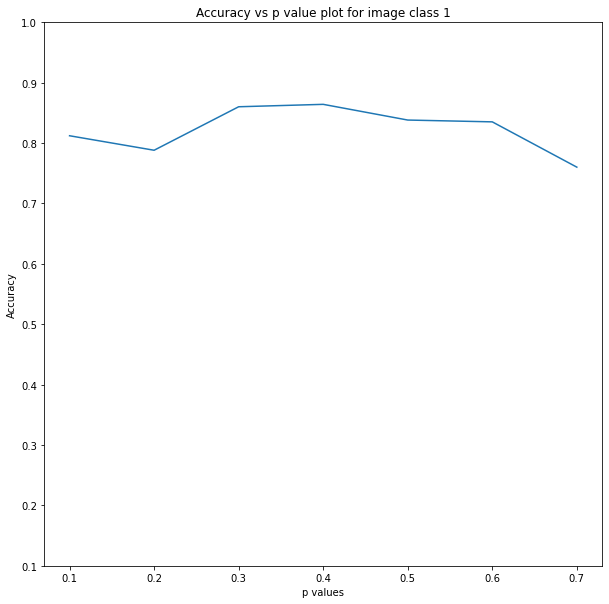

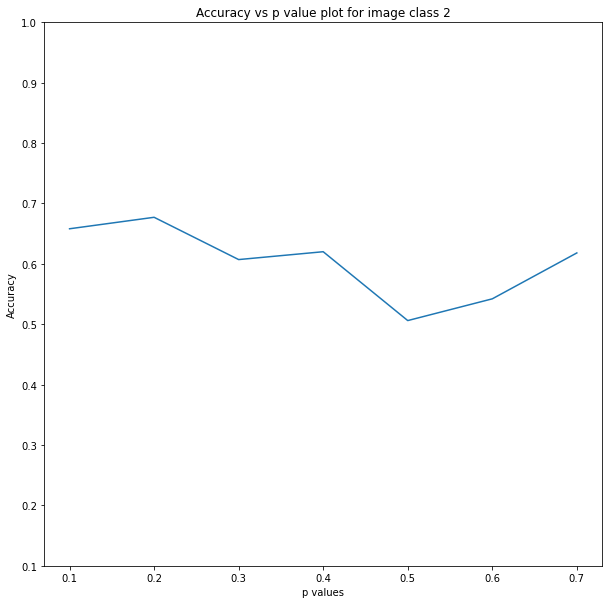

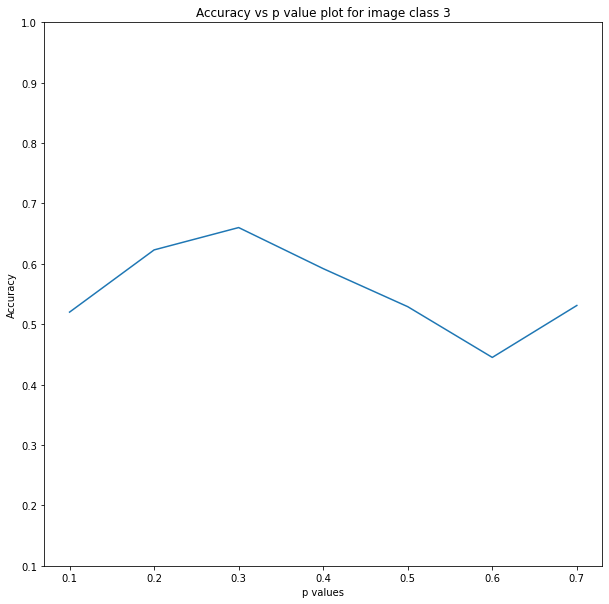

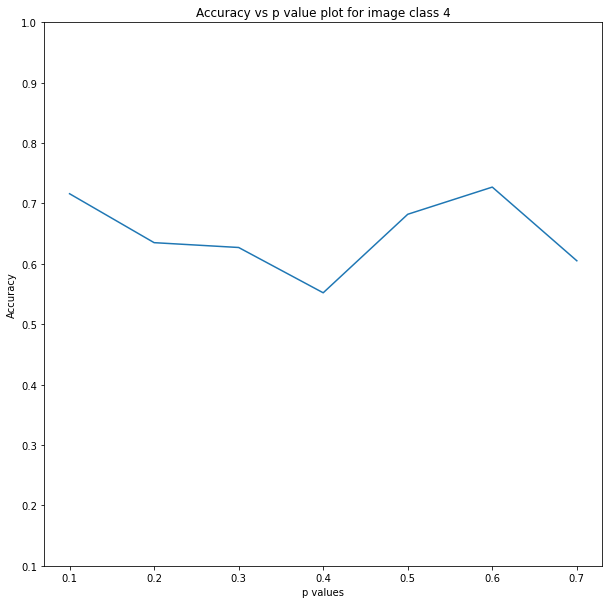

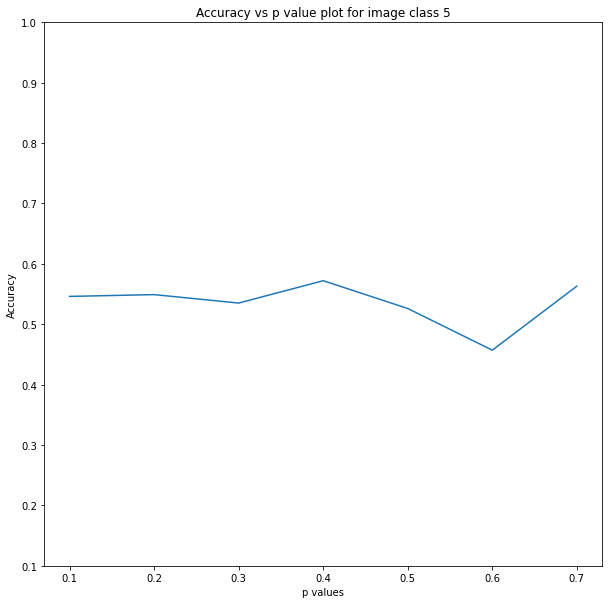

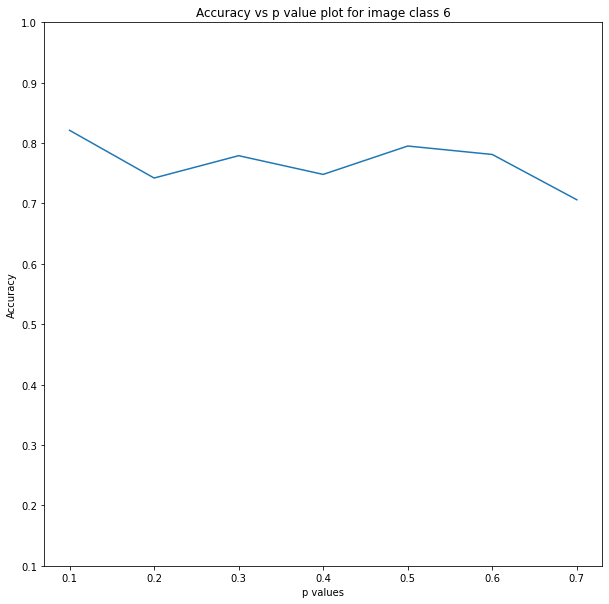

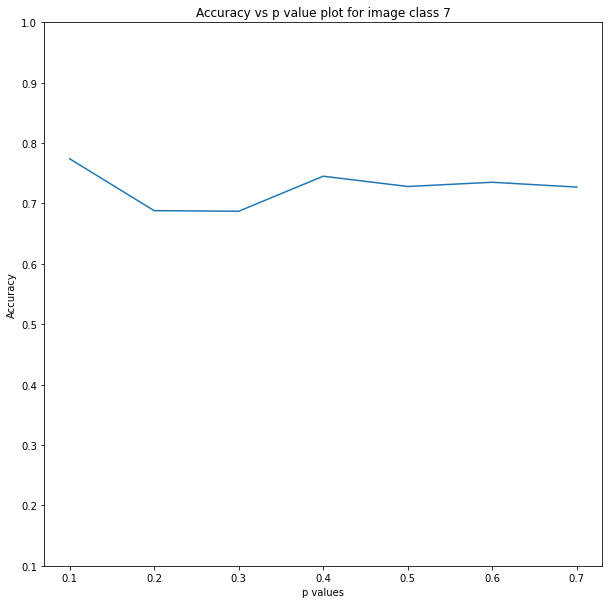

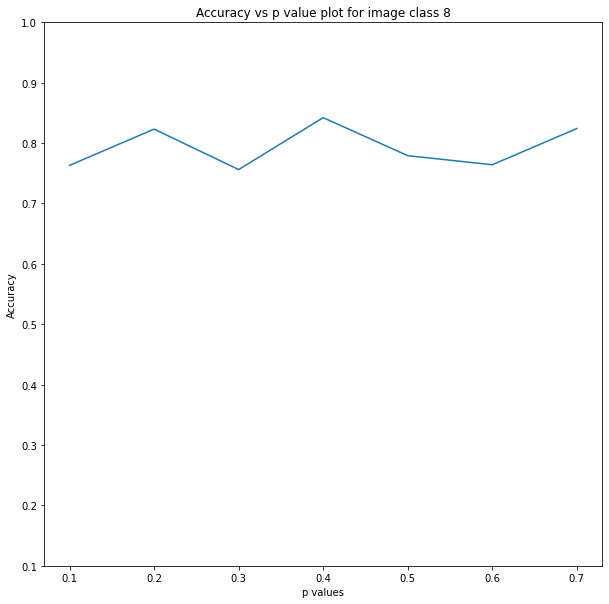

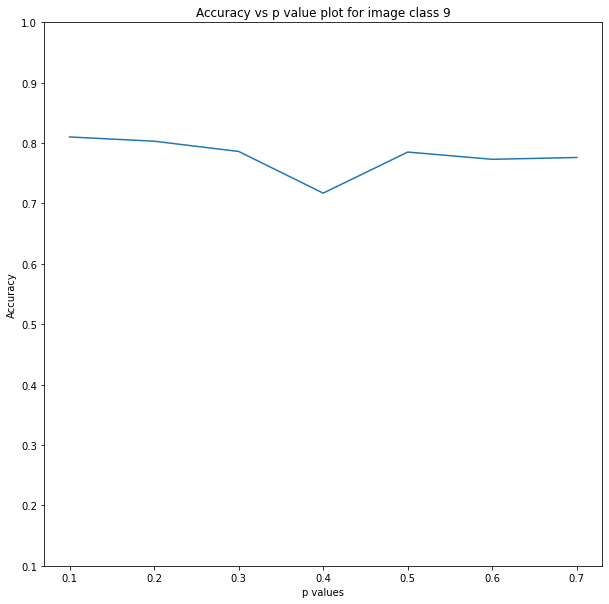

In [8]:
for i in range(10) :
    plt.figure(figsize=[10, 10])
    plt.plot(np.arange(0.1, 0.8, 0.1), correct[:, i]/total[:, i])
    plt.ylabel('Accuracy')
    plt.xlabel('p values')
    plt.title(f'Accuracy vs p value plot for image class {i}')
    plt.ylim(0.1, 1)
    plt.show()